In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

Time Series Data Exploration for ride demand


In [2]:
df = pd.read_csv('/Users/jiaxinye/NYC-taxi-data-science-project copy/data/clean_train.csv')

In [3]:
df.head(5)

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,pickup_date,date,minimum temperature,precipitation,snow fall,snow depth,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,2016-03-14,2016-03-14 00:00:00,40,0.29,0.0,0.0,6.122493,1.498521,1.735433,99.970196
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,2016-06-12,2016-06-12 00:00:00,37,0.35,0.0,0.0,6.498282,1.805507,2.430506,-117.153768
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,2016-01-19,2016-01-19 00:00:00,16,0.00,0.0,0.0,7.661527,6.385098,8.203575,-159.680165
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,2016-04-06,2016-04-06 00:00:00,66,0.40,0.0,0.0,6.063785,1.485498,1.661331,-172.737700
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,2016-03-26,2016-03-26 00:00:00,38,0.00,0.0,0.0,6.077642,1.188588,1.199457,179.473585


In [4]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear
#https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

Text(0.5, 1.0, 'Number of Rides over the Year')

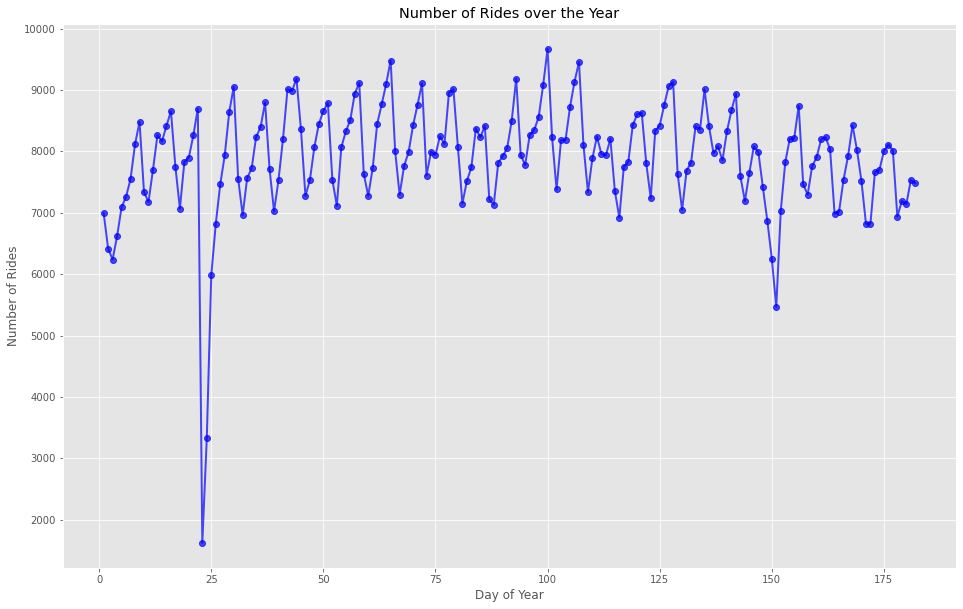

In [5]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('dayofyear').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

In [6]:
#view the time series of number of rides per day
#To investigate possible sequence dependencies (such as periods) in time series, 
#we need to create "lagging" copies of the series
count =  df.groupby('dayofyear').count()['id']
ts = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')
ts.head()

,count
day,
1,6993
2,6415
3,6238
4,6620
5,7088


In [7]:
#the lagged time series
ts_lagged = ts.shift()
ts_lagged.head()

,count
day,
1,NaN
2,6993.0
3,6415.0
4,6238.0
5,6620.0


Text(0.5, 1.0, 'Number of Rides over the Year')

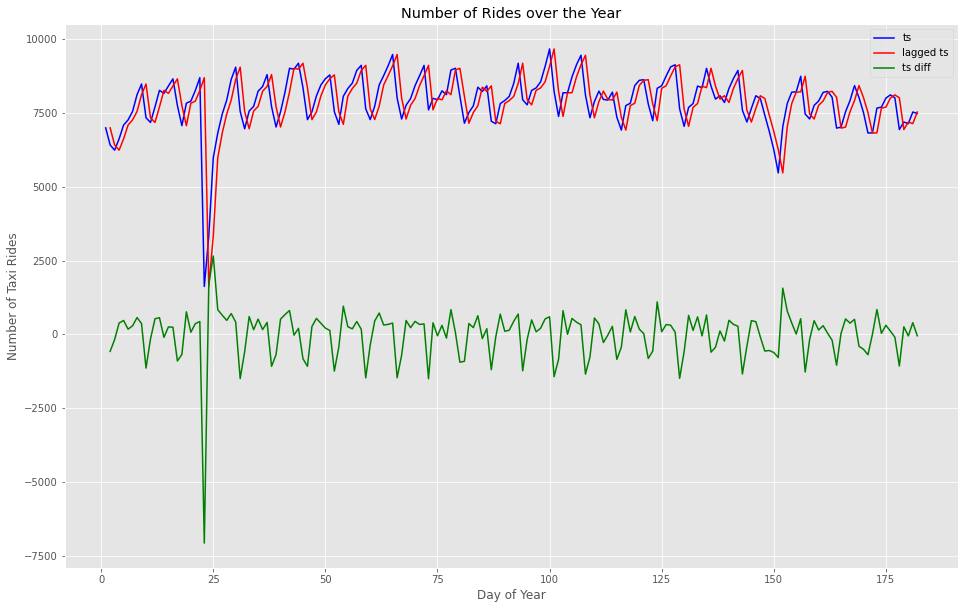

In [8]:
#view the three time series data on one plot

plt1 =  plt.plot(ts, color = 'blue', label = 'ts')
plt2 = plt.plot(ts_lagged, color = 'red', label = 'lagged ts')
plt3 = plt.plot(ts - ts_lagged, color = 'green', label = 'ts diff')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Number of Taxi Rides')
plt.title('Number of Rides over the Year')

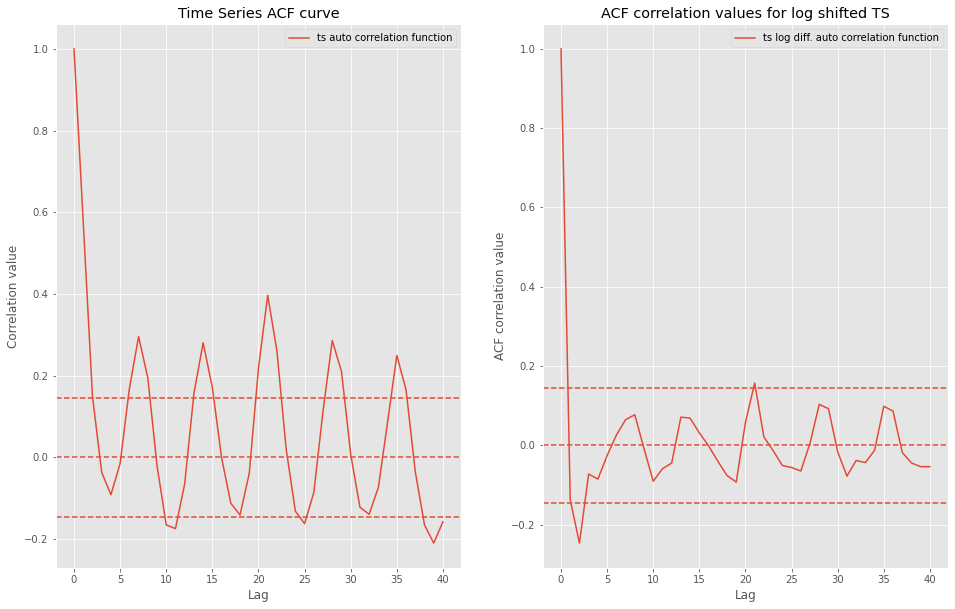

In [9]:
#auto-correlation function
#AR model makes use of the correlation between the early value and the late value (autocorrelation) to establish a regression equation containing the early value and the late value, 
#so as to achieve the purpose of prediction. Therefore, it becomes an autoregressive process
from statsmodels.tsa import stattools
#create the log shifted time series

log_ts = np.log(ts)
log_ts_diff = log_ts - log_ts.shift()
log_ts_diff.dropna(inplace = True) #drop na values

acf_result1 = stattools.acf(ts)
plt.subplot(1,2,1)
plt.plot(acf_result1, label = 'ts auto correlation function')
plt.axhline(y=0,linestyle='--')
#creating the 2 std dev dotted lines
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--')
plt.ylabel('Correlation value')
plt.xlabel('Lag')
plt.title('Time Series ACF curve')
plt.legend()


acf_result2 = stattools.acf(log_ts_diff)
plt.subplot(1,2,2)
plt.plot(acf_result2, label = 'ts log diff. auto correlation function')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.xlabel('Lag')
plt.ylabel('ACF correlation value')
plt.title('ACF correlation values for log shifted TS')
plt.legend()

In [ ]:
#the data shows trends and seasonality, we need to remove it by detrending the data through logs and differences, moving average, linear regression, etc.


In [10]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(log_ts_diff['count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})


,Value,Label
0,-9.262704e+00,Test Statistic
1,9.325540e-14,p-value
2,5.000000e+00,#Lags Used
3,1.750000e+02,Number of Observations Used
4,-4.011455e+00,Critical value for 1%
5,-3.435882e+00,Critical value for 5%
6,-3.141957e+00,Critical value for 10%


/Users/jiaxinye/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/jiaxinye/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/jiaxinye/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/jiaxinye/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and w

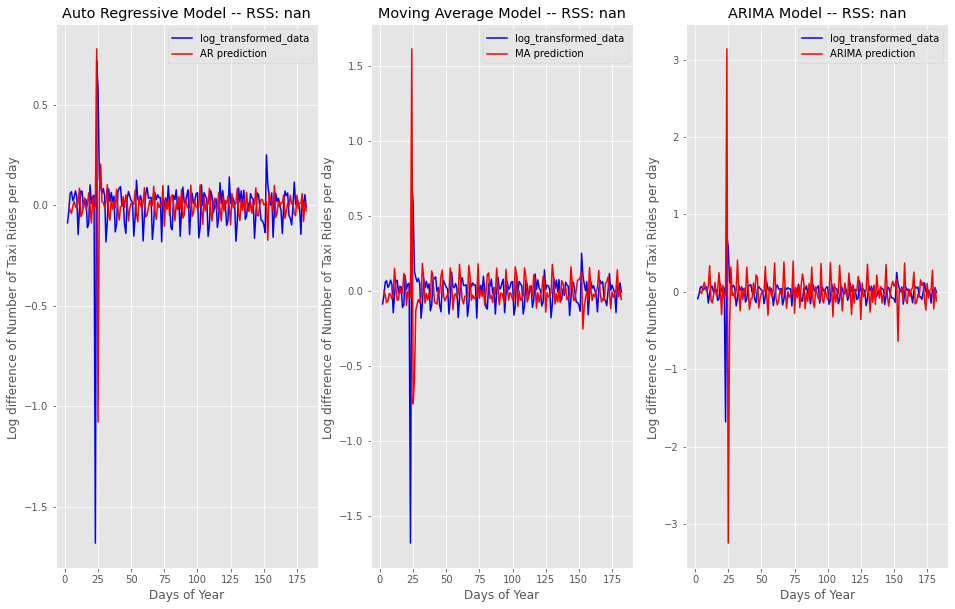

In [11]:
#forecasting
from statsmodels.tsa.arima_model import ARIMA
# AR model
# try different values of p
model = ARIMA(log_ts_diff, order=(1, 1, 0))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_AR = model.fit(disp=-1)  
plt.subplot(1,3,1)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_AR.fittedvalues, color='red', label= 'AR prediction')
plt.title('Auto Regressive Model -- RSS: %.4f'% sum((results_AR.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

# MA model
# try different values of p
model = ARIMA(log_ts_diff, order=(0, 1, 1))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_MA = model.fit(disp=-1)  
plt.subplot(1,3,2)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_MA.fittedvalues, color='red', label= 'MA prediction')
plt.title('Moving Average Model -- RSS: %.4f'% sum((results_MA.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()


# ARIMA model
# try different values of p
model = ARIMA(log_ts_diff, order=(1,2,3))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_ARIMA = model.fit(disp=-1)  
plt.subplot(1,3,3)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_ARIMA.fittedvalues, color='red', label= 'ARIMA prediction')
plt.title('ARIMA Model -- RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

In [12]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

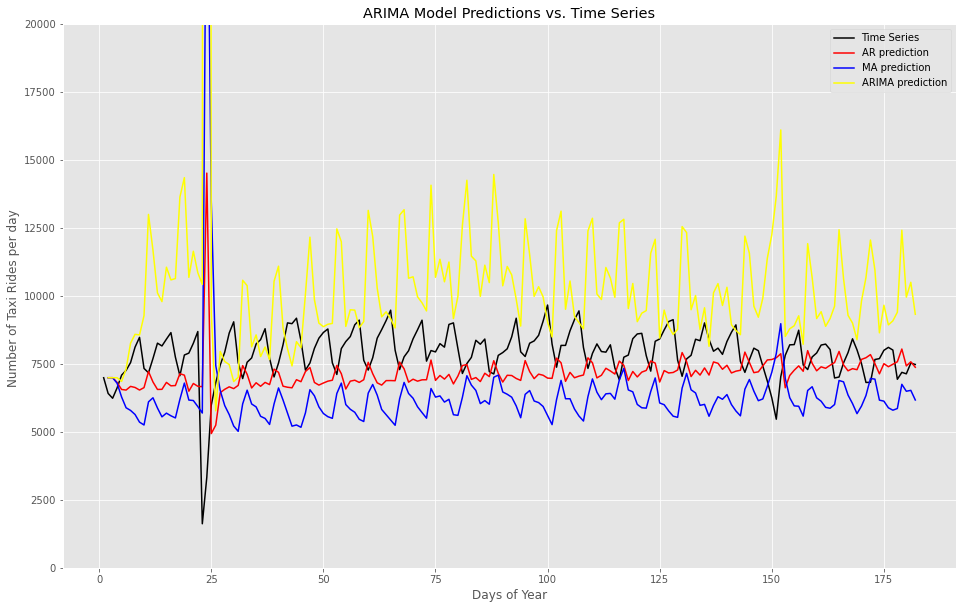

In [13]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum() 
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum() 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() 

predictions_AR_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)

predictions_MA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)

predictions_ARIMA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_AR = np.exp(predictions_AR_log)
predictions_MA = np.exp(predictions_MA_log)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(ts, color = 'black', label = 'Time Series')
plt.plot(predictions_AR, color =  'red', label = 'AR prediction')
plt.plot(predictions_MA, color = 'blue', label = 'MA prediction')
plt.plot(predictions_ARIMA, color =  'yellow', label = 'ARIMA prediction')
plt.ylim(0, 20000)  
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per day ')
plt.title('ARIMA Model Predictions vs. Time Series')
plt.legend()